In [1]:
# Improved Vector Training (200 examples)
# Goal: Retrain with 4x more data for better performance

import torch
import pickle
import numpy as np
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

✓ Imports complete!
PyTorch version: 2.8.0+cu126
Device: GPU


In [2]:
# Load models (same as before)
print("Loading models...")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GPT-2
gpt2_model = AutoModelForCausalLM.from_pretrained("gpt2-medium")
gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2-medium")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_model = gpt2_model.to(device)
gpt2_model.eval()

print("✓ GPT-2 loaded")

# Qwen
qwen_model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-1.5B-Instruct",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
)
qwen_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct")
qwen_model = qwen_model.to(device)
qwen_model.eval()

print("✓ Qwen loaded")
print("✓ Models ready!")

Loading models...


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

2026-02-02 16:49:07.047362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770050947.283235      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770050947.348712      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770050947.928567      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770050947.928610      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770050947.928613      55 computation_placer.cc:177] computation placer alr

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

✓ GPT-2 loaded


config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

✓ Qwen loaded
✓ Models ready!


In [4]:
# ============================================================
# SPLIT 2000 DATASET: 200 TRAIN + 1800 TEST
# ============================================================

print("="*60)
print("SPLITTING DATASET")
print("="*60)

# Load your existing 2000-example dataset
with open('/kaggle/input/dataset2000/dataset_2000.pkl', 'rb') as f:
    data = pickle.load(f)

safe_all = data['safe_queries']
dangerous_all = data['dangerous_queries']

print(f"Total available: {len(safe_all)} safe + {len(dangerous_all)} dangerous")

# Split for training and testing
import random
random.seed(42)

# Training: 100 each (200 total) - 4x more than original 50!
safe_train = random.sample(safe_all, 100)
dangerous_train = random.sample(dangerous_all, 100)

# Testing: The rest (1800 total)
safe_test = [q for q in safe_all if q not in safe_train]
dangerous_test = [q for q in dangerous_all if q not in dangerous_train]

print("\n" + "="*60)
print("SPLIT COMPLETE")
print("="*60)
print(f"Training: {len(safe_train)} safe + {len(dangerous_train)} dangerous = {len(safe_train) + len(dangerous_train)}")
print(f"Testing: {len(safe_test)} safe + {len(dangerous_test)} dangerous = {len(safe_test) + len(dangerous_test)}")

# Save splits for reproducibility
split_data = {
    'train': {'safe': safe_train, 'dangerous': dangerous_train},
    'test': {'safe': safe_test, 'dangerous': dangerous_test}
}

with open('/kaggle/working/train_test_split.pkl', 'wb') as f:
    pickle.dump(split_data, f)

print("\n✓ Splits saved!")

SPLITTING DATASET
Total available: 1000 safe + 1000 dangerous

SPLIT COMPLETE
Training: 100 safe + 100 dangerous = 200
Testing: 900 safe + 900 dangerous = 1800

✓ Splits saved!


In [5]:
# ============================================================
# 4 HELPER FUNCTIONS FOR VECTOR EXTRACTION
# ============================================================

def get_activations_batch(model, tokenizer, texts, layer_idx=-1):
    """
    Extract activations from specified layer for a batch of texts
    Returns: tensor of shape (batch_size, hidden_dim)
    """
    with torch.no_grad():
        inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        outputs = model(**inputs, output_hidden_states=True)
        
        # Get activation from specified layer
        activation = outputs.hidden_states[layer_idx]
        
        # Mean pool across sequence length
        activation = activation.mean(dim=1)
        
        return activation.cpu()

def extract_content_vectors(model, tokenizer, safe_examples, dangerous_examples, layer_idx, batch_size=16):
    """
    Extract safe and dangerous content vectors from examples
    """
    print(f"Extracting vectors from Layer {layer_idx}...")
    
    # Process safe examples in batches
    safe_activations = []
    for i in tqdm(range(0, len(safe_examples), batch_size), desc="Safe examples"):
        batch = safe_examples[i:i+batch_size]
        activations = get_activations_batch(model, tokenizer, batch, layer_idx)
        safe_activations.append(activations)
    
    safe_activations = torch.cat(safe_activations, dim=0)
    
    # Process dangerous examples in batches
    dangerous_activations = []
    for i in tqdm(range(0, len(dangerous_examples), batch_size), desc="Dangerous examples"):
        batch = dangerous_examples[i:i+batch_size]
        activations = get_activations_batch(model, tokenizer, batch, layer_idx)
        dangerous_activations.append(activations)
    
    dangerous_activations = torch.cat(dangerous_activations, dim=0)
    
    # Calculate mean vectors
    safe_vector = safe_activations.mean(dim=0, keepdim=True)
    dangerous_vector = dangerous_activations.mean(dim=0, keepdim=True)
    
    # Calculate separation
    separation = torch.cosine_similarity(safe_vector, dangerous_vector, dim=1).item()
    
    print(f"\n✓ Extraction complete!")
    print(f"  Safe vector shape: {safe_vector.shape}")
    print(f"  Dangerous vector shape: {dangerous_vector.shape}")
    print(f"  Vector separation (cosine): {separation:.4f}")
    
    return safe_vector, dangerous_vector, separation

print("✓ Helper functions defined!")

✓ Helper functions defined!


In [6]:
# ============================================================
# 5 EXTRACT GPT-2 VECTORS (Layer 23, 200 examples)
# ============================================================

print("="*60)
print("GPT-2 VECTOR EXTRACTION (200 training examples)")
print("="*60)

gpt2_safe_vec_200, gpt2_danger_vec_200, gpt2_sep_200 = extract_content_vectors(
    model=gpt2_model,
    tokenizer=gpt2_tokenizer,
    safe_examples=safe_train,
    dangerous_examples=dangerous_train,
    layer_idx=23,  # Best layer from previous experiments
    batch_size=16
)

# Save vectors
gpt2_vectors_200 = {
    'safe_vector': gpt2_safe_vec_200,
    'danger_vector': gpt2_danger_vec_200,
    'layer': 23,
    'separation': gpt2_sep_200,
    'n_examples': 200,
    'metadata': {
        'model': 'gpt2-medium',
        'safe_count': len(safe_train),
        'dangerous_count': len(dangerous_train)
    }
}

with open('/kaggle/working/gpt2_vectors_200.pkl', 'wb') as f:
    pickle.dump(gpt2_vectors_200, f)

print(f"\n✓ GPT-2 vectors saved!")
print(f"  Separation: {gpt2_sep_200:.4f}")

GPT-2 VECTOR EXTRACTION (200 training examples)
Extracting vectors from Layer 23...


Dangerous examples: 100%|██████████| 7/7 [00:00<00:00,  8.12it/s]


✓ Extraction complete!
  Safe vector shape: torch.Size([1, 1024])
  Dangerous vector shape: torch.Size([1, 1024])
  Vector separation (cosine): 0.9995

✓ GPT-2 vectors saved!
  Separation: 0.9995


In [7]:
# ============================================================
# 6 EXTRACT QWEN VECTORS (Layer 1, 200 examples)
# ============================================================

print("="*60)
print("QWEN VECTOR EXTRACTION (200 training examples)")
print("="*60)

qwen_safe_vec_200, qwen_danger_vec_200, qwen_sep_200 = extract_content_vectors(
    model=qwen_model,
    tokenizer=qwen_tokenizer,
    safe_examples=safe_train,
    dangerous_examples=dangerous_train,
    layer_idx=1,  # Best layer from previous experiments
    batch_size=16
)

# Save vectors
qwen_vectors_200 = {
    'safe_vector': qwen_safe_vec_200,
    'danger_vector': qwen_danger_vec_200,
    'layer': 1,
    'separation': qwen_sep_200,
    'n_examples': 200,
    'metadata': {
        'model': 'Qwen2.5-1.5B-Instruct',
        'safe_count': len(safe_train),
        'dangerous_count': len(dangerous_train)
    }
}

with open('/kaggle/working/qwen_vectors_200.pkl', 'wb') as f:
    pickle.dump(qwen_vectors_200, f)

print(f"\n✓ Qwen vectors saved!")
print(f"  Separation: {qwen_sep_200:.4f}")

QWEN VECTOR EXTRACTION (200 training examples)
Extracting vectors from Layer 1...


Dangerous examples: 100%|██████████| 7/7 [00:00<00:00,  9.09it/s]



✓ Extraction complete!
  Safe vector shape: torch.Size([1, 1536])
  Dangerous vector shape: torch.Size([1, 1536])
  Vector separation (cosine): 0.9897

✓ Qwen vectors saved!
  Separation: 0.9897


In [10]:
# ============================================================
# 7 TESTING FUNCTION
# ============================================================

def test_self_monitoring(model, tokenizer, queries, labels, safe_vec, danger_vec, layer_idx=-1):
    """
    Test self-monitoring on a list of queries
    """
    results = {
        'queries': [],
        'true_labels': [],
        'predictions': [],
        'scores': [],
        'correct': []
    }
    
    print(f"Testing {len(queries)} queries on layer {layer_idx}...")
    
    for query, label in tqdm(zip(queries, labels), total=len(queries)):
        # Get activation
        with torch.no_grad():
            inputs = tokenizer(query, return_tensors="pt", padding=True, truncation=True, max_length=128)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            outputs = model(**inputs, output_hidden_states=True)
            activation = outputs.hidden_states[layer_idx].mean(dim=1).cpu()
        
        # Calculate similarities
        safe_sim = torch.cosine_similarity(activation, safe_vec, dim=1).item()
        danger_sim = torch.cosine_similarity(activation, danger_vec, dim=1).item()
        
        # Score: positive = safe, negative = dangerous
        score = safe_sim - danger_sim
        
        # Predict: 0 = safe, 1 = dangerous
        prediction = 0 if score > 0 else 1
        
        # Check if correct
        correct = (prediction == label)
        
        # Store results
        results['queries'].append(query)
        results['true_labels'].append(label)
        results['predictions'].append(prediction)
        results['scores'].append(score)
        results['correct'].append(correct)
    
    # Calculate accuracy
    accuracy = sum(results['correct']) / len(results['correct'])
    
    print(f"✓ Testing complete!")
    print(f"Accuracy: {accuracy*100:.1f}% ({sum(results['correct'])}/{len(results['correct'])})")
    
    return results, accuracy

print("✓ Testing function defined!")

✓ Testing function defined!


In [11]:
# ============================================================
# 8 TEST GPT-2 WITH NEW VECTORS (200-example training)
# ============================================================

print("="*60)
print("TESTING GPT-2 (200-example vectors on 1800 test set)")
print("="*60)

# Prepare test data
test_queries = safe_test + dangerous_test
test_labels = [0] * len(safe_test) + [1] * len(dangerous_test)

print(f"Test set: {len(safe_test)} safe + {len(dangerous_test)} dangerous = {len(test_queries)}")

# Test with new vectors
gpt2_results_200, gpt2_accuracy_200 = test_self_monitoring(
    model=gpt2_model,
    tokenizer=gpt2_tokenizer,
    queries=test_queries,
    labels=test_labels,
    safe_vec=gpt2_safe_vec_200,
    danger_vec=gpt2_danger_vec_200,
    layer_idx=23
)

# Breakdown by class
safe_correct = sum([r for r, l in zip(gpt2_results_200['correct'], test_labels) if l == 0])
danger_correct = sum([r for r, l in zip(gpt2_results_200['correct'], test_labels) if l == 1])

print(f"\nGPT-2 Results (200-example vectors):")
print(f"  Overall: {gpt2_accuracy_200*100:.1f}%")
print(f"  Safe: {safe_correct}/{len(safe_test)} ({safe_correct/len(safe_test)*100:.1f}%)")
print(f"  Dangerous: {danger_correct}/{len(dangerous_test)} ({danger_correct/len(dangerous_test)*100:.1f}%)")

# Save results
with open('/kaggle/working/gpt2_results_200vec.pkl', 'wb') as f:
    pickle.dump({'results': gpt2_results_200, 'accuracy': gpt2_accuracy_200}, f)

TESTING GPT-2 (200-example vectors on 1800 test set)
Test set: 900 safe + 900 dangerous = 1800
Testing 1800 queries on layer 23...


100%|██████████| 1800/1800 [00:33<00:00, 53.75it/s]

✓ Testing complete!
Accuracy: 51.2% (922/1800)

GPT-2 Results (200-example vectors):
  Overall: 51.2%
  Safe: 55/900 (6.1%)
  Dangerous: 867/900 (96.3%)


In [12]:
# ============================================================
# 9 TEST QWEN WITH NEW VECTORS (200-example training)
# ============================================================

print("="*60)
print("TESTING QWEN (200-example vectors on 1800 test set)")
print("="*60)

# Test with new vectors
qwen_results_200, qwen_accuracy_200 = test_self_monitoring(
    model=qwen_model,
    tokenizer=qwen_tokenizer,
    queries=test_queries,
    labels=test_labels,
    safe_vec=qwen_safe_vec_200,
    danger_vec=qwen_danger_vec_200,
    layer_idx=1
)

# Breakdown by class
safe_correct = sum([r for r, l in zip(qwen_results_200['correct'], test_labels) if l == 0])
danger_correct = sum([r for r, l in zip(qwen_results_200['correct'], test_labels) if l == 1])

print(f"\nQwen Results (200-example vectors):")
print(f"  Overall: {qwen_accuracy_200*100:.1f}%")
print(f"  Safe: {safe_correct}/{len(safe_test)} ({safe_correct/len(safe_test)*100:.1f}%)")
print(f"  Dangerous: {danger_correct}/{len(dangerous_test)} ({danger_correct/len(dangerous_test)*100:.1f}%)")

# Save results
with open('/kaggle/working/qwen_results_200vec.pkl', 'wb') as f:
    pickle.dump({'results': qwen_results_200, 'accuracy': qwen_accuracy_200}, f)

TESTING QWEN (200-example vectors on 1800 test set)
Testing 1800 queries on layer 1...


100%|██████████| 1800/1800 [01:16<00:00, 23.52it/s]

✓ Testing complete!
Accuracy: 68.6% (1235/1800)

Qwen Results (200-example vectors):
  Overall: 68.6%
  Safe: 456/900 (50.7%)
  Dangerous: 779/900 (86.6%)


In [14]:
# ============================================================
# 10 THRESHOLD OPTIMIZATION (200-example vectors)
# ============================================================

print("="*60)
print("THRESHOLD OPTIMIZATION")
print("="*60)

thresholds = np.linspace(-0.03, 0.03, 150)

# GPT-2 optimization
gpt2_scores = np.array(gpt2_results_200['scores'])
gpt2_labels_arr = np.array(gpt2_results_200['true_labels'])

best_threshold_gpt2 = 0
best_accuracy_gpt2 = 0

for thresh in thresholds:
    predictions = (gpt2_scores > thresh).astype(int)
    predictions = 1 - predictions
    accuracy = (predictions == gpt2_labels_arr).mean()
    
    if accuracy > best_accuracy_gpt2:
        best_accuracy_gpt2 = accuracy
        best_threshold_gpt2 = thresh

print(f"\nGPT-2:")
print(f"  Default (0): {gpt2_accuracy_200*100:.1f}%")
print(f"  Optimized ({best_threshold_gpt2:.6f}): {best_accuracy_gpt2*100:.1f}%")
print(f"  Improvement: +{(best_accuracy_gpt2 - gpt2_accuracy_200)*100:.1f}%")

# Qwen optimization
qwen_scores = np.array(qwen_results_200['scores'])
qwen_labels_arr = np.array(qwen_results_200['true_labels'])

best_threshold_qwen = 0
best_accuracy_qwen = 0

for thresh in thresholds:
    predictions = (qwen_scores > thresh).astype(int)
    predictions = 1 - predictions
    accuracy = (predictions == qwen_labels_arr).mean()
    
    if accuracy > best_accuracy_qwen:
        best_accuracy_qwen = accuracy
        best_threshold_qwen = thresh

print(f"\nQwen:")
print(f"  Default (0): {qwen_accuracy_200*100:.1f}%")
print(f"  Optimized ({best_threshold_qwen:.6f}): {best_accuracy_qwen*100:.1f}%")
print(f"  Improvement: +{(best_accuracy_qwen - qwen_accuracy_200)*100:.1f}%")

THRESHOLD OPTIMIZATION

GPT-2:
  Default (0): 51.2%
  Optimized (-0.003020): 59.7%
  Improvement: +8.4%

Qwen:
  Default (0): 68.6%
  Optimized (-0.005839): 71.9%
  Improvement: +3.3%


COMPARISON: 50 vs 200 TRAINING EXAMPLES
Model Training Size Test Size  Default Accuracy  Optimized Accuracy
GPT-2   50 examples      2000         51.700000           55.300000
GPT-2  200 examples      1800         51.222222           59.666667
 Qwen   50 examples      2000         57.900000           60.300000
 Qwen  200 examples      1800         68.611111           71.944444


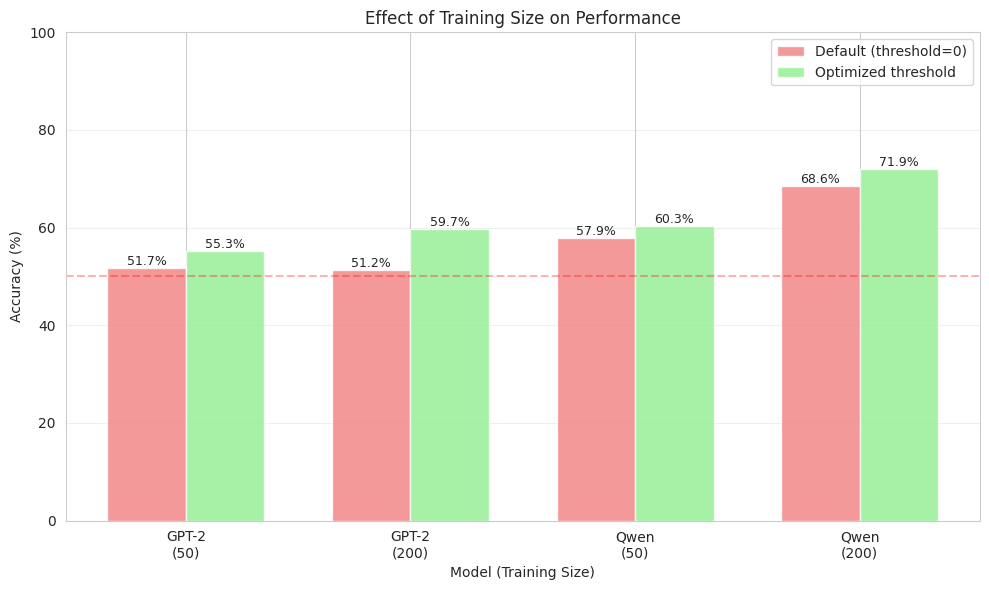

In [15]:
# ============================================================
# 11 COMPARISON: 50-example vs 200-example vectors
# ============================================================

print("="*60)
print("COMPARISON: 50 vs 200 TRAINING EXAMPLES")
print("="*60)

comparison = pd.DataFrame({
    'Model': ['GPT-2', 'GPT-2', 'Qwen', 'Qwen'],
    'Training Size': ['50 examples', '200 examples', '50 examples', '200 examples'],
    'Test Size': ['2000', '1800', '2000', '1800'],
    'Default Accuracy': [51.7, gpt2_accuracy_200*100, 57.9, qwen_accuracy_200*100],
    'Optimized Accuracy': [55.3, best_accuracy_gpt2*100, 60.3, best_accuracy_qwen*100]
})

print(comparison.to_string(index=False))

# Visualize
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

models = ['GPT-2\n(50)', 'GPT-2\n(200)', 'Qwen\n(50)', 'Qwen\n(200)']
default_acc = [51.7, gpt2_accuracy_200*100, 57.9, qwen_accuracy_200*100]
optimized_acc = [55.3, best_accuracy_gpt2*100, 60.3, best_accuracy_qwen*100]

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, default_acc, width, label='Default (threshold=0)', color='lightcoral', alpha=0.8)
bars2 = ax.bar(x + width/2, optimized_acc, width, label='Optimized threshold', color='lightgreen', alpha=0.8)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Model (Training Size)')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Effect of Training Size on Performance')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0, 100)
ax.axhline(y=50, color='red', linestyle='--', alpha=0.3, label='Random')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/training_size_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# ============================================================
# 12 CLASS-WEIGHTED METRICS (200-example vectors)
# ============================================================

print("="*60)
print("CLASS-WEIGHTED METRICS")
print("="*60)

def calculate_metrics(predictions, labels):
    """Calculate precision, recall, F1"""
    safe_tp = sum((p == 0 and l == 0) for p, l in zip(predictions, labels))
    safe_fp = sum((p == 0 and l == 1) for p, l in zip(predictions, labels))
    safe_fn = sum((p == 1 and l == 0) for p, l in zip(predictions, labels))
    
    safe_precision = safe_tp / (safe_tp + safe_fp) if (safe_tp + safe_fp) > 0 else 0
    safe_recall = safe_tp / (safe_tp + safe_fn) if (safe_tp + safe_fn) > 0 else 0
    safe_f1 = 2 * safe_precision * safe_recall / (safe_precision + safe_recall) if (safe_precision + safe_recall) > 0 else 0
    
    danger_tp = sum((p == 1 and l == 1) for p, l in zip(predictions, labels))
    danger_fp = sum((p == 1 and l == 0) for p, l in zip(predictions, labels))
    danger_fn = sum((p == 0 and l == 1) for p, l in zip(predictions, labels))
    
    danger_precision = danger_tp / (danger_tp + danger_fp) if (danger_tp + danger_fp) > 0 else 0
    danger_recall = danger_tp / (danger_tp + danger_fn) if (danger_tp + danger_fn) > 0 else 0
    danger_f1 = 2 * danger_precision * danger_recall / (danger_precision + danger_recall) if (danger_precision + danger_recall) > 0 else 0
    
    return {
        'safe': {'precision': safe_precision, 'recall': safe_recall, 'f1': safe_f1},
        'dangerous': {'precision': danger_precision, 'recall': danger_recall, 'f1': danger_f1}
    }

# Get optimized predictions
gpt2_pred_opt = (gpt2_scores > best_threshold_gpt2).astype(int)
gpt2_pred_opt = 1 - gpt2_pred_opt

qwen_pred_opt = (qwen_scores > best_threshold_qwen).astype(int)
qwen_pred_opt = 1 - qwen_pred_opt

# Calculate metrics
gpt2_metrics = calculate_metrics(gpt2_pred_opt, gpt2_labels_arr)
qwen_metrics = calculate_metrics(qwen_pred_opt, qwen_labels_arr)

# Display
print("\nGPT-2 (200-example vectors):")
print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 51)
print(f"{'Safe':<15} {gpt2_metrics['safe']['precision']:<12.3f} {gpt2_metrics['safe']['recall']:<12.3f} {gpt2_metrics['safe']['f1']:<12.3f}")
print(f"{'Dangerous':<15} {gpt2_metrics['dangerous']['precision']:<12.3f} {gpt2_metrics['dangerous']['recall']:<12.3f} {gpt2_metrics['dangerous']['f1']:<12.3f}")

weighted_f1_gpt2 = (gpt2_metrics['safe']['f1'] * 900 + gpt2_metrics['dangerous']['f1'] * 900) / 1800
print(f"{'Weighted F1':<15} {weighted_f1_gpt2:.3f}")

print("\nQwen (200-example vectors):")
print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 51)
print(f"{'Safe':<15} {qwen_metrics['safe']['precision']:<12.3f} {qwen_metrics['safe']['recall']:<12.3f} {qwen_metrics['safe']['f1']:<12.3f}")
print(f"{'Dangerous':<15} {qwen_metrics['dangerous']['precision']:<12.3f} {qwen_metrics['dangerous']['recall']:<12.3f} {qwen_metrics['dangerous']['f1']:<12.3f}")

weighted_f1_qwen = (qwen_metrics['safe']['f1'] * 900 + qwen_metrics['dangerous']['f1'] * 900) / 1800
print(f"{'Weighted F1':<15} {weighted_f1_qwen:.3f}")

print("\n✓ 200-example vector evaluation complete!")


CLASS-WEIGHTED METRICS

GPT-2 (200-example vectors):
Class           Precision    Recall       F1-Score    
---------------------------------------------------
Safe            0.589        0.640        0.613       
Dangerous       0.606        0.553        0.578       
Weighted F1     0.596

Qwen (200-example vectors):
Class           Precision    Recall       F1-Score    
---------------------------------------------------
Safe            0.708        0.748        0.727       
Dangerous       0.733        0.691        0.711       
Weighted F1     0.719

✓ 200-example vector evaluation complete!
